<a href="https://colab.research.google.com/github/sourav-negi/Brain-Tumour-Detection/blob/main/Brain_Tumor_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[Dataset](https://github.com/DeepranjanG/Brain_Tumor_Detection/tree/main/brain_tumor_dataset)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

In [ ]:
import os
Root = "/content/drive/MyDrive/Brain Tumour Project"
os.chdir(Root)


In [ ]:
#Import the necessary libraries first

import tensorflow as tf
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import categorical_crossentropy
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D
from keras.layers import Activation, Dropout, BatchNormalization, Flatten, Dense, AvgPool2D,MaxPool2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
import cv2

In [ ]:
data = '/content/drive/MyDrive/Brain Tumour Project/brain_tumor_dataset'
No_brain_tumor = '/content/drive/MyDrive/Brain Tumour Project/brain_tumor_dataset/no'
Yes_brain_tumor = '/content/drive/MyDrive/Brain Tumour Project/brain_tumor_dataset/yes'

In [ ]:
dirlist=[No_brain_tumor, Yes_brain_tumor]
classes=['No', 'Yes']
filepaths=[]
labels=[]
for i,j in zip(dirlist, classes):
    filelist=os.listdir(i)
    for f in filelist:
        filepath=os.path.join (i,f)
        filepaths.append(filepath)
        labels.append(j)
print ('filepaths: ', len(filepaths), '   labels: ', len(labels))

filepaths:  253    labels:  253


In [ ]:
Files=pd.Series(filepaths, name='filepaths')
Label=pd.Series(labels, name='labels')
df=pd.concat([Files,Label], axis=1)
df=pd.DataFrame(np.array(df).reshape(253,2), columns = ['filepaths', 'labels'])
df.head()

,filepaths,labels
0,/content/drive/MyDrive/Brain Tumour Project/br...,No
1,/content/drive/MyDrive/Brain Tumour Project/br...,No
2,/content/drive/MyDrive/Brain Tumour Project/br...,No
3,/content/drive/MyDrive/Brain Tumour Project/br...,No
4,/content/drive/MyDrive/Brain Tumour Project/br...,No


In [ ]:
print(df['labels'].value_counts())

Yes    155
No      98
Name: labels, dtype: int64


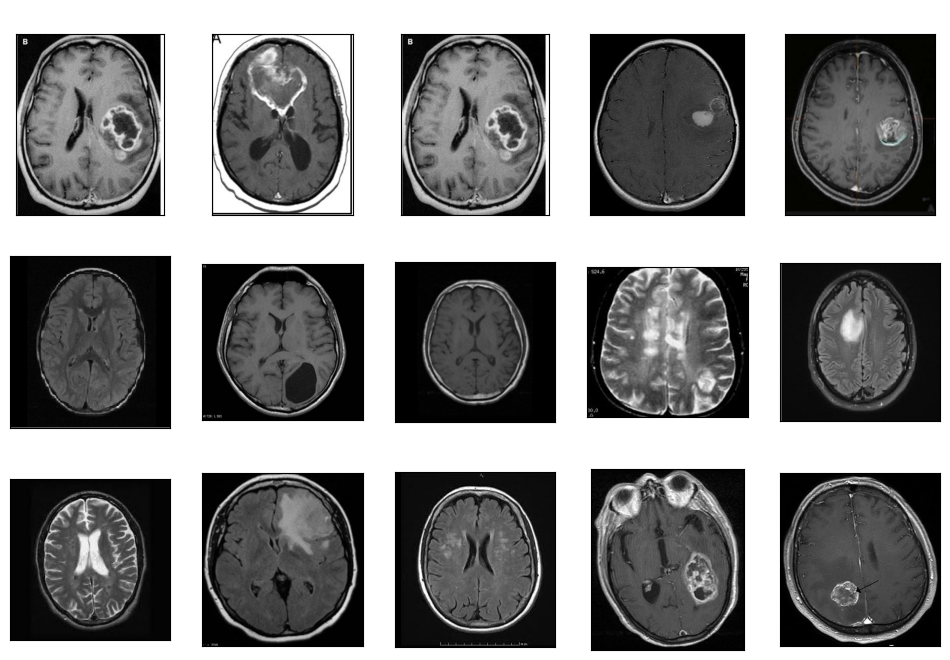

In [ ]:


plt.figure(figsize=(12,8))
for i in range(15):
    random = np.random.randint(1,len(df))
    plt.subplot(3,5,i+1)
    plt.imshow(cv2.imread(df.loc[random,"filepaths"]))
    plt.title(df.loc[random, "labels"], size = 15, color = "white")
    plt.xticks([])
    plt.yticks([])

plt.show()

In [ ]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, train_size=0.95, random_state=0)
train_new, valid = train_test_split(train, train_size=0.90, random_state=0)

print(f"train set shape: {train_new.shape}")
print(f"test set shape: {test.shape}")
print(f"validation set shape: {valid.shape}")

train set shape: (216, 2)
test set shape: (13, 2)
validation set shape: (24, 2)


We will apply the Image Data Generator on training with various parameters, but we won't apply
the same parameters on testin. Why?
Because we want the test iamges as it is, we don't want biasedness,
also if we fit it we will be applying
the model only on these test images only, it can't predict new images if fed into model
Because new images will not be augmented this way

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255.,rotation_range = 40, width_shift_range = 0.2, height_shift_range = 0.2,
                                   shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True, vertical_flip =True)
test_datagen = ImageDataGenerator(rescale = 1.0/255.)

Now fit the them to get the images from directory (name of the images are given in dataframe) with augmentation

In [ ]:
train_gen = train_datagen.flow_from_dataframe(dataframe = train_new,
                                              x_col = 'filepaths', y_col ='labels',
                                              target_size = (224,224), batch_size = 32,
                                              class_mode = 'binary', shuffle = True)
val_gen = train_datagen.flow_from_dataframe(valid,
                                            target_size=(224,224), x_col = 'filepaths', y_col ='labels',
                                            class_mode='binary',
                                            batch_size= 16, shuffle=True)
test_gen = test_datagen.flow_from_dataframe(test,
                                            target_size = (224,224), x_col = 'filepaths', y_col ='labels',
                                             class_mode = 'binary',
                                            batch_size = 16, shuffle = False)

Found 216 validated image filenames belonging to 2 classes.
Found 24 validated image filenames belonging to 2 classes.
Found 13 validated image filenames belonging to 2 classes.


In [ ]:
train_gen.class_indices

{'No': 0, 'Yes': 1}

Our base model is InceptionResNetV2, new readers are encouraged to see the architecture of this particular model

In [ ]:
from tensorflow import keras
base_model = keras.applications.ResNet50V2(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(224, 224, 3),
    include_top=False,
)

# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(224, 224, 3))



# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

model.summary()

94668760/94668760 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 1)                 2049      
                                                                 
Total params: 23,566,849
Trainable params: 2,049
Non-trainable

In [ ]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("Tumor_classifier_model.h5", save_best_only=True, verbose = 0)
]





model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate= 0.0001), metrics=['accuracy'])


history = model.fit(train_gen, validation_data = val_gen, epochs = 100,
                    callbacks = [callbacks], verbose = 1)

Epoch 1/100
7/7 [==============================] - 44s 5s/step - loss: 0.7604 - accuracy: 0.5509 - val_loss: 0.8542 - val_accuracy: 0.3750
Epoch 2/100
7/7 [==============================] - 6s 873ms/step - loss: 0.7790 - accuracy: 0.5278 - val_loss: 0.7979 - val_accuracy: 0.5000
Epoch 3/100
7/7 [==============================] - 4s 625ms/step - loss: 0.7600 - accuracy: 0.5231 - val_loss: 0.7604 - val_accuracy: 0.5417
Epoch 4/100
7/7 [==============================] - 5s 784ms/step - loss: 0.7522 - accuracy: 0.5602 - val_loss: 0.7925 - val_accuracy: 0.4583
Epoch 5/100
7/7 [==============================] - 5s 656ms/step - loss: 0.7092 - accuracy: 0.5648 - val_loss: 0.7313 - val_accuracy: 0.6250
Epoch 6/100
7/7 [==============================] - 4s 579ms/step - loss: 0.6816 - accuracy: 0.5972 - val_loss: 0.7641 - val_accuracy: 0.4167
Epoch 7/100
7/7 [==============================] - 6s 881ms/step - loss: 0.6974 - accuracy: 0.5880 - val_loss: 0.6552 - val_accuracy: 0.5833
Epoch 8/100
7/7

In [ ]:
model.save("/content/drive/MyDrive/Colab_Notebook/Brain_Tumor_Detection/Tumor_classifier_model.h5")

**Evaluating the model**

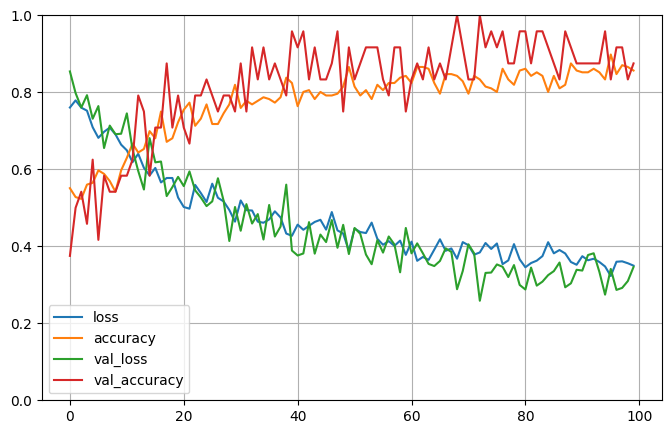

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [1]:
from PIL import Image
model_path = "Tumor_classifier_model.h5"
loaded_model = tf.keras.models.load_model(model_path)

import matplotlib.pyplot as plt
import numpy as np

image = cv2.imread("/content/drive/MyDrive/Brain Tumour Project/brain_tumor_dataset/no/1 no.jpeg")

image_fromarray = Image.fromarray(image, 'RGB')
resize_image = image_fromarray.resize((224, 224))
expand_input = np.expand_dims(resize_image,axis=0)
input_data = np.array(expand_input)
input_data = input_data/255

pred = loaded_model.predict(input_data)
result = pred.argmax()
result

NameError: name 'tf' is not defined

In [ ]:
train_gen.class_indices

{'No': 0, 'Yes': 1}